In [1]:
import torch
from pg_modules.ti_slots import SlotRecreater
from matplotlib import pyplot as plt

In [2]:
sr = SlotRecreater()

In [3]:
import os
import random
import json
import numpy as np
from PIL import Image
import torch
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.dataloader import default_collate
import json

class Image_Dataset(Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, resolution=(128, 128), root_dir="/home/benedikthopf/Dokumente/9. Semester/datasets/CANDLE", filetype="png"):
        super(Image_Dataset, self).__init__()
        self.resolution = resolution

        assert split in ['train', 'val', 'test']
        self.split = split
        self.root_dir = root_dir
        # self.root_dir = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"
        self.files = [file for file in os.listdir(
            self.root_dir) if file.endswith(f".{filetype}")]
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]
        self.img_transform = transforms.Compose([
            transforms.ToTensor()])

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)
        sample = {'image': image}

        return sample

    def __len__(self):
        return len(self.files)
    
class CLEVER(Image_Dataset):
    def __init__(self, split='train', max_num_samples=np.inf, max_num_objects=6, **kwargs):
        if "root_dir" not in kwargs.keys():
            kwargs["root_dir"] = "/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/images/train"

        super().__init__(
            split,
            max_num_samples=np.inf,
            **kwargs
        )
        with open("/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/scenes/CLEVR_train_scenes.json", "r") as f:
            scenes = json.load(f)

        self.max_num_objects = max_num_objects
        valid_scenes = list(filter(lambda x: len(
            x["objects"]) <= max_num_objects, scenes["scenes"]))
        valid_image_numbers = set(
            map(lambda x: x["image_filename"], valid_scenes))
        self.files = list(filter(
            lambda x: x in valid_image_numbers,
            self.files
        ))
        if len(self.files) > max_num_samples:
            self.files = self.files[:max_num_samples]

        self.files = sorted(self.files)
        self.scenes = sorted(valid_scenes, key=lambda x: x["image_filename"])

        with open("/home/benedikthopf/Dokumente/9. Semester/datasets/CLEVER/questions/CLEVR_train_questions.json", "r") as f:
            questions = json.load(f)["questions"]
        self.questions_by_image_index = {}
        for question in questions:
            i = question["image_index"]
            try:
                self.questions_by_image_index[i].append(question["question"])
            except KeyError:
                self.questions_by_image_index[i] = [question["question"]]

    def get_picture_object_count(self, file, scenes):
        for scene in scenes["scenes"]:
            if scene["image_filename"] == file:
                return len(scene["objects"])
        raise Exception(f"filename {file} not in scenes!")

    def __getitem__(self, index):
        path = self.files[index]
        image = Image.open(os.path.join(self.root_dir, path)).convert("RGB")
        image = image.resize(self.resolution)
        image = self.img_transform(image)

        o = self.scenes[index]["objects"]
        dummy = dict(o[0])
        dummy["shape"] = "None"  # dummy object, since the dataloader wants it
        objects = np.array([dummy for _ in range(self.max_num_objects)])
        for i in range(len(o)):
            objects[i] = o[i]
        objects = list(objects)

        sample = {
            'image': image,
            'question': np.random.choice(self.questions_by_image_index[index]),
            'objects': objects
        }

        return sample

In [4]:
ds = CLEVER()

In [7]:
_, _, out = sr(ds[1]["image"].unsqueeze(0))

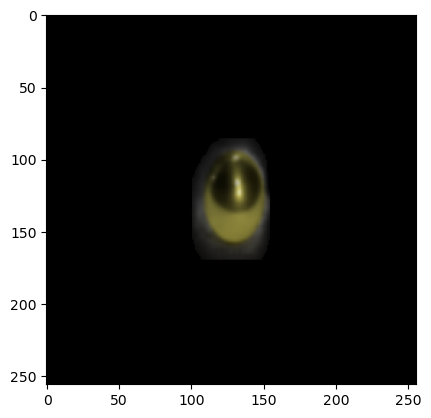

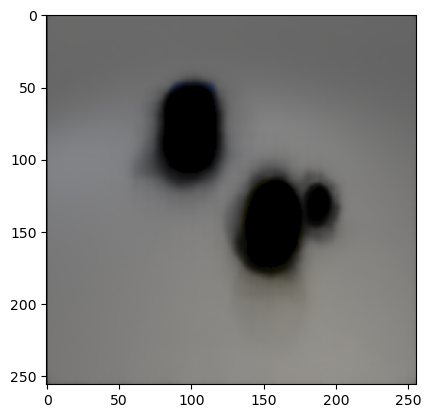

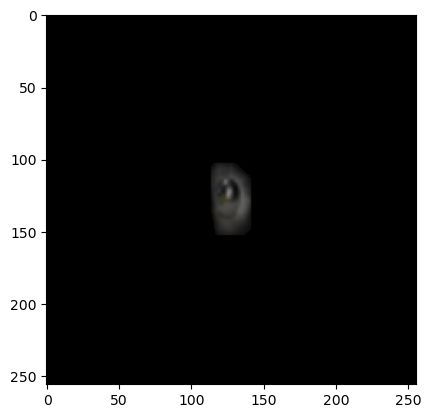

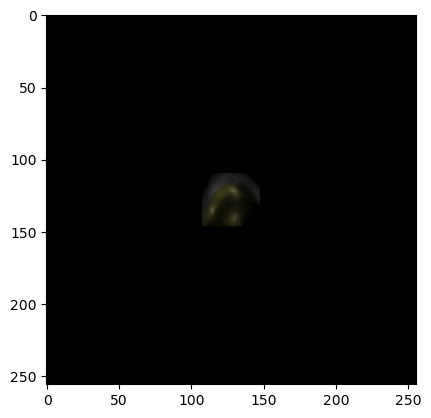

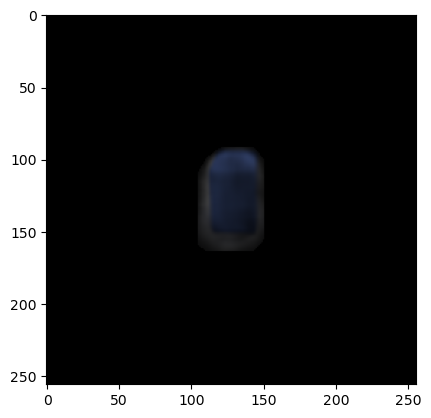

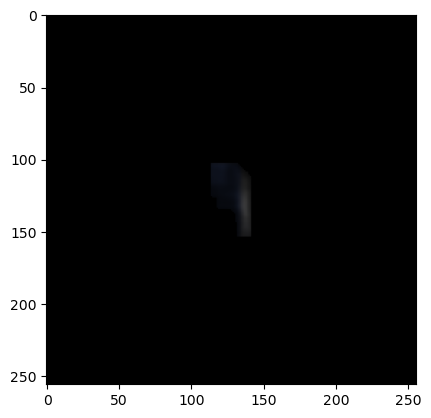

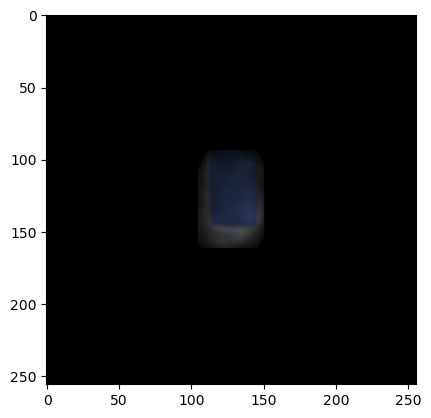

In [8]:
for img in out["masked_images"]:
    plt.imshow(img.permute(1, 2, 0).detach().cpu().numpy())
    plt.show()